In [2]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, f1_score, auc
from sklearn.model_selection import train_test_split
from keras import layers, Model
from keras.models import Sequential, load_model
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers, layers, losses
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, PrecisionRecallDisplay
from keras.utils import plot_model
import pandas as pd
import seaborn as sns
import joblib
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

(39000, 14)
(40000, 14)
(40000, 14)


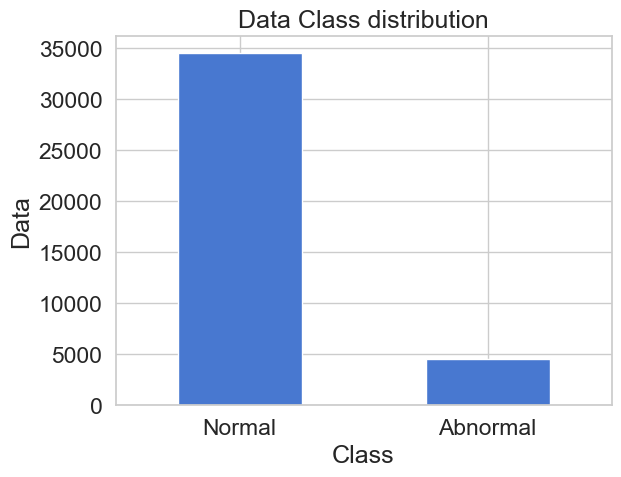

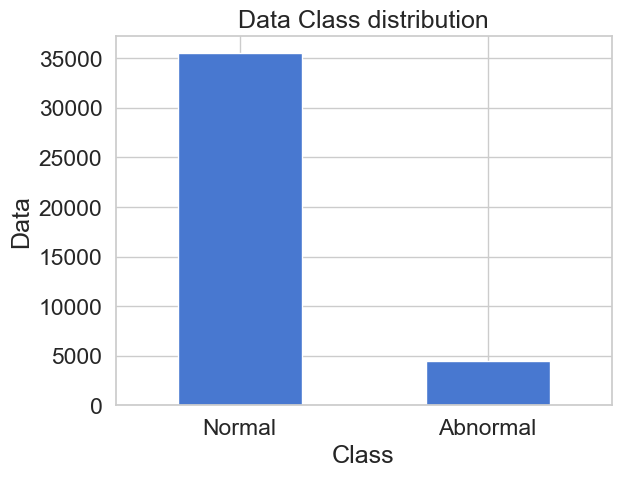

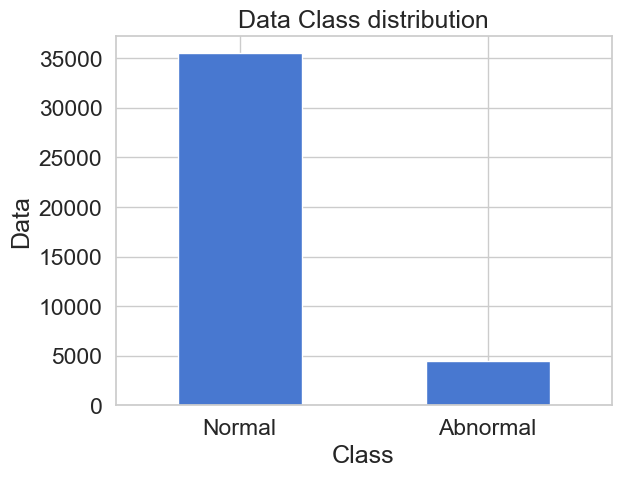

In [3]:
# Generate some sample data for the autoencoder
# x_train = np.random.rand(1000, 12)
# x_test = np.random.rand(100, 12)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

RANDOM_SEED = 42

df = pd.read_csv("Autoencoder1.csv")  
print(df.shape)

df2 = pd.read_csv("Autoencoder_wind.csv")
print(df2.shape)

df3 = pd.read_csv("Autoencoder_wind2.csv")
print(df3.shape)

LABELS = ["Normal", "Abnormal"]

count_classes =pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Data Class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Data")
plt.show();

count_classes2 =pd.value_counts(df2['Class'], sort = True)
count_classes2.plot(kind = 'bar', rot=0)
plt.title("Data Class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Data")
plt.show();

count_classes3 =pd.value_counts(df3['Class'], sort = True)
count_classes3.plot(kind = 'bar', rot=0)
plt.title("Data Class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Data")
plt.show();

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from cmath import pi

data = df.drop(['Time'], axis=1)
# y_true = df['Class']

r2d = 180/pi

data['P'] = r2d * data['P']
data['Q'] = r2d * data['Q']
data['R'] = r2d * data['R']
data['Phi'] = r2d * data['Phi']
data['Theta'] = r2d * data['Theta']
data['Psi'] = r2d * data['Psi']

data2 = df2.drop(['Time'], axis=1)
# y_true2 = df2['Class']

r2d = 180/pi

data2['P'] = r2d * data2['P']
data2['Q'] = r2d * data2['Q']
data2['R'] = r2d * data2['R']
data2['Phi'] = r2d * data2['Phi']
data2['Theta'] = r2d * data2['Theta']
data2['Psi'] = r2d * data2['Psi']

data3 = df3.drop(['Time'], axis=1)
# y_true2 = df2['Class']

r2d = 180/pi

data3['P'] = r2d * data3['P']
data3['Q'] = r2d * data3['Q']
data3['R'] = r2d * data3['R']
data3['Phi'] = r2d * data3['Phi']
data3['Theta'] = r2d * data3['Theta']
data3['Psi'] = r2d * data3['Psi']

In [4]:
X_train, X_test = train_test_split(data2, test_size=0.5, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
y_train = X_train['Class']
X_train = pd.DataFrame(X_train)
X_train = X_train.drop(['Class'], axis=1)

# X_test = X_test[X_test.Class == 0]
y_test = X_test['Class']
X_test = pd.DataFrame(X_test)
X_test = X_test.drop(['Class'], axis=1)

def MinmaxNorm(data1, data2, label):
    for i in label:
        a = data1[i]
        b = data2[i]
        x_max = max(a)
        x_min = min(a)
        for j in list(range(a.shape[0])):
            a.iloc[j] = (a.iloc[j] - x_min) / (x_max - x_min)
        for k in list(range(b.shape[0])):
            b.iloc[k] = (b.iloc[k] - x_min) / (x_max - x_min)
    
    return data1, data2

A = ['RPM1', 'RPM2', 'RPM3', 'RPM4', 'RPM5', 'RPM6', 'P', 'Q', 'R', 'Phi', 'Theta', 'Psi']

X_train, X_test = MinmaxNorm(X_train, X_test, A)

X_train = X_train.values
X_test = X_test.values

In [25]:
def calculate_result(AE_model):
    k = load_model(AE_model)
    pred1 = k.predict(X_train)
    pred2 = k.predict(X_test)
    mse = np.mean(np.power((X_train - pred1), 2), axis=1)
    mse2 = np.mean(np.power((X_test - pred2), 2), axis=1)
    rmse1 = np.sqrt(mse)
    rmse2 = np.sqrt(mse2)
    thresholds = max(rmse1)
    error_df = pd.DataFrame({'reconstruction_error': rmse2,
                            'true_class': y_test})

    error_df.reconstruction_error = error_df.reconstruction_error >= thresholds
    error_df['reconstruction_error'] = error_df['reconstruction_error'].astype(int)

    y_pred = error_df.reconstruction_error
    precision, recall, thresholds1 = precision_recall_curve(y_test, y_pred)
    fpr, tpr, thresholds2 = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    dic1 = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}
    dic2 = {'precision': precision, 'recall': recall, 'f1': f1, 'conf_matrix': conf_matrix}
    df = [dic1, dic2]
    
    return df

def calculate_result2(AE_model, GMM_model, rate):
    dic = {}
    k = load_model(AE_model)
    encoded_test_data = k.encoder(X_test).numpy()
    l = joblib.load(GMM_model)
    scores=l.score_samples(encoded_test_data)

    for n in rate:
        threshold = np.percentile(scores, n)
        y_pred = np.zeros_like(scores)
        y_pred[scores < threshold] = 1
        precision, recall, thresholds1 = precision_recall_curve(y_test, y_pred)
        fpr, tpr, thresholds2 = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        f1 = f1_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        dic1 = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}
        dic2 = {'precision': precision, 'recall': recall, 'f1': f1, 'conf_matrix': conf_matrix}
        dic[n] = [dic1, dic2]

    df = [dic]
        
    return df

def calculate_result3(AE_model, GMM_model, rate):
    dic = {}
    k = load_model(AE_model)
    encoded_test_data = k.encoder(X_test).numpy()
    l = joblib.load(GMM_model)
    scores=l.score_samples(encoded_test_data)

    for n in rate:
        threshold = np.percentile(scores, n)
        y_pred = np.zeros_like(scores)
        y_pred[scores < threshold] = 1
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = 2*(precision*recall)/(precision+recall)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        dic1 = {}
        dic2 = {'precision': precision, 'recall': recall, 'f1': f1, 'conf_matrix': conf_matrix}
        dic[n] = [dic1, dic2]

    df = [dic]
        
    return df

def calculate_result4(AE_model):
    k = load_model(AE_model)
    pred1 = k.predict(X_train)
    pred2 = k.predict(X_test)
    mse = np.mean(np.power((X_train - pred1), 2), axis=1)
    mse2 = np.mean(np.power((X_test - pred2), 2), axis=1)
    rmse1 = np.sqrt(mse)
    rmse2 = np.sqrt(mse2)
    thresholds = max(rmse1)
    error_df = pd.DataFrame({'reconstruction_error': rmse2,
                            'true_class': y_test})

    error_df.reconstruction_error = error_df.reconstruction_error >= thresholds
    error_df['reconstruction_error'] = error_df['reconstruction_error'].astype(int)

    y_pred = error_df.reconstruction_error
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = 2*(precision*recall)/(precision+recall)
    conf_matrix = confusion_matrix(y_test, y_pred)
    dic1 = {}
    dic2 = {'precision': precision, 'recall': recall, 'f1': f1, 'conf_matrix': conf_matrix}
    df = [dic1, dic2]
    
    return df

In [27]:
def results_plot(AE_model, Model_Names):
    fig, ax = plt.subplots(figsize=[10, 10])
    sns.set_palette("bright")
    for i in Model_Names:
        ax.plot(AE_model[i][1]['precision'], AE_model[i][1]['recall'], label='{} = %0.4f'.format(i)% AE_model[i][1]['f1'])
    ax.set_xlabel("Precision")
    ax.set_ylabel("Recall")
    ax.set_title("Precision-Recall curve")
    ax.legend(loc='lower left', prop={'size': 15})
    axins = ax.inset_axes([0.3, 0.2, 0.45, 0.45])

    for i in Model_Names:
        axins.plot(AE_model[i][1]['precision'], AE_model[i][1]['recall'])
    
    x1, x2, y1, y2 = 0.95, 1.01, 0.95, 1.01
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    for axis in ['top', 'bottom', 'left', 'right']:
        axins.spines[axis].set_linewidth(3)
        axins.spines[axis].set_color('k')

    axins.set_xticks([])
    axins.set_yticks([])
    axins.grid()

    # indicator = ax.indicate_inset_zoom(axins, edgecolor="black", linewidth = 3)
    indicator = ax.indicate_inset_zoom(axins)
    indicator[0].set_linewidth(3)
    indicator[0].set_edgecolor('k')
    # indicator[0].set_color('k')

    indicator[1][0].set_linewidth(3)
    indicator[1][1].set_linewidth(3)
    indicator[1][2].set_linewidth(3)
    indicator[1][3].set_linewidth(3)

    indicator[1][1].set_color('k')
    indicator[1][2].set_color('k')

def results_plot2(GMM_model, Model_Names, rate):
    fig, ax = plt.subplots(figsize=[10, 10])
    sns.set_palette("bright")
    
    ax.plot(GMM_model[Model_Names[0]][0][rate[20]][1]['precision'], GMM_model[Model_Names[0]][0][rate[20]][1]['recall'], label='{} = %0.4f'.format(Model_Names[0]) % GMM_model[Model_Names[0]][0][rate[20]][1]['f1'])
    ax.plot(GMM_model[Model_Names[1]][0][rate[4]][1]['precision'], GMM_model[Model_Names[1]][0][rate[4]][1]['recall'], label='{} = %0.4f'.format(Model_Names[1]) % GMM_model[Model_Names[1]][0][rate[4]][1]['f1'])
    # ax.plot(GMM_model[Model_Names[2]][0][rate[-4]][1]['precision'], GMM_model[Model_Names[2]][0][rate[-4]][1]['recall'], label='{} = %0.4f'.format(Model_Names[2]) % GMM_model[Model_Names[2]][0][rate[-4]][1]['f1'])
    # ax.plot(GMM_model[Model_Names[3]][0][rate[-6]][1]['precision'], GMM_model[Model_Names[3]][0][rate[-6]][1]['recall'], label='{} = %0.4f'.format(Model_Names[3]) % GMM_model[Model_Names[3]][0][rate[-6]][1]['f1'])
    
    ax.set_xlabel("Precision")
    ax.set_ylabel("Recall")
    ax.set_title("Precision-Recall curve")
    ax.legend(loc='lower left', prop={'size': 15})
    # axins = ax.inset_axes([0.3, 0.2, 0.45, 0.45])

    # axins.plot(GMM_model[Model_Names[0]][0][rate[20]][1]['precision'], GMM_model[Model_Names[0]][0][rate[20]][1]['recall'])
    # axins.plot(GMM_model[Model_Names[1]][0][rate[4]][1]['precision'], GMM_model[Model_Names[1]][0][rate[4]][1]['recall'])
    # axins.plot(GMM_model[Model_Names[2]][0][rate[-4]][1]['precision'], GMM_model[Model_Names[2]][0][rate[-4]][1]['recall'])
    # axins.plot(GMM_model[Model_Names[3]][0][rate[-6]][1]['precision'], GMM_model[Model_Names[3]][0][rate[-6]][1]['recall'])
    
    # x1, x2, y1, y2 = 0.92, 1.01, 0.92, 1.01
    # axins.set_xlim(x1, x2)
    # axins.set_ylim(y1, y2)

    # for axis in ['top', 'bottom', 'left', 'right']:
    #     axins.spines[axis].set_linewidth(3)
    #     axins.spines[axis].set_color('k')

    # axins.set_xticks([])
    # axins.set_yticks([])
    # axins.grid()

    # # indicator = ax.indicate_inset_zoom(axins, edgecolor="black", linewidth = 3)
    # indicator = ax.indicate_inset_zoom(axins)
    # indicator[0].set_linewidth(3)
    # indicator[0].set_edgecolor('k')
    # # indicator[0].set_color('k')

    # indicator[1][0].set_linewidth(3)
    # indicator[1][1].set_linewidth(3)
    # indicator[1][2].set_linewidth(3)
    # indicator[1][3].set_linewidth(3)

    # indicator[1][1].set_color('k')
    # indicator[1][2].set_color('k')

def results_plot3(AE_model, GMM_model,  Model_Names1, Model_Names2, rate):
    fig, ax = plt.subplots(figsize=[10, 10])
    sns.set_palette("bright")
    
    for i in Model_Names1:
        ax.plot(AE_model[i][1]['precision'], AE_model[i][1]['recall'], label='{} = %0.4f'.format(i) % AE_model[i][1]['f1'])
        
    ax.plot(GMM_model[Model_Names2[0]][0][rate[20]][1]['precision'], GMM_model[Model_Names2[0]][0][rate[20]][1]['recall'], label='{} = %0.4f'.format(Model_Names2[0]) % GMM_model[Model_Names2[0]][0][rate[20]][1]['f1'])
    # ax.plot(GMM_model[Model_Names2[1]][0][rate[4]][1]['precision'], GMM_model[Model_Names2[1]][0][rate[4]][1]['recall'], label='{} = %0.4f'.format(Model_Names2[1]) % GMM_model[Model_Names2[1]][0][rate[4]][1]['f1'])
    # ax.plot(GMM_model[Model_Names2[2]][0][rate[-4]][1]['precision'], GMM_model[Model_Names2[2]][0][rate[-4]][1]['recall'], label='{} = %0.4f'.format(Model_Names2[2]) % GMM_model[Model_Names2[2]][0][rate[-4]][1]['f1'])
    # ax.plot(GMM_model[Model_Names2[3]][0][rate[-6]][1]['precision'], GMM_model[Model_Names2[3]][0][rate[-6]][1]['recall'], label='{} = %0.4f'.format(Model_Names2[3]) % GMM_model[Model_Names2[3]][0][rate[-6]][1]['f1'])
    ax.set_xlabel("Precision")
    ax.set_ylabel("Recall")
    ax.set_title("Precision-Recall curve")
    ax.legend(loc='lower left', prop={'size': 15})
    axins = ax.inset_axes([0.3, 0.2, 0.45, 0.45])
    
    for i in Model_Names1:
        axins.plot(AE_model[i][1]['precision'], AE_model[i][1]['recall'], label='{} = %0.4f'.format(i) % AE_model[i][1]['f1'])
        
    axins.plot(GMM_model[Model_Names2[0]][0][rate[20]][1]['precision'], GMM_model[Model_Names2[0]][0][rate[20]][1]['recall'])
    # axins.plot(GMM_model[Model_Names2[1]][0][rate[4]][1]['precision'], GMM_model[Model_Names2[1]][0][rate[4]][1]['recall'])
    # axins.plot(GMM_model[Model_Names2[2]][0][rate[-4]][1]['precision'], GMM_model[Model_Names2[2]][0][rate[-4]][1]['recall'])
    # axins.plot(GMM_model[Model_Names2[3]][0][rate[-6]][1]['precision'], GMM_model[Model_Names2[3]][0][rate[-6]][1]['recall'])
    
    x1, x2, y1, y2 = 0.95, 1.01, 0.95, 1.01
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    for axis in ['top', 'bottom', 'left', 'right']:
        axins.spines[axis].set_linewidth(3)
        axins.spines[axis].set_color('k')

    axins.set_xticks([])
    axins.set_yticks([])
    axins.grid()

    # indicator = ax.indicate_inset_zoom(axins, edgecolor="black", linewidth = 3)
    indicator = ax.indicate_inset_zoom(axins)
    indicator[0].set_linewidth(3)
    indicator[0].set_edgecolor('k')
    # indicator[0].set_color('k')

    indicator[1][0].set_linewidth(3)
    indicator[1][1].set_linewidth(3)
    indicator[1][2].set_linewidth(3)
    indicator[1][3].set_linewidth(3)

    indicator[1][1].set_color('k')
    indicator[1][2].set_color('k')


In [7]:
def GMM_Rate_Select(GMM_model, Model_Names2, rate):
    fig, ax = plt.subplots(figsize=[10, 10])
    sns.set_palette("bright")
    
    for j in rate:
        ax.plot(GMM_model[Model_Names2][0][j][1]['precision'], GMM_model[Model_Names2][0][j][1]['recall'], label='{0:.1f} = %0.4f'.format(j) % GMM_model[Model_Names2][0][j][1]['f1'])
        ax.set_xlabel("Precision")
        ax.set_ylabel("Recall")
        ax.set_title("Precision-Recall curve")
        ax.legend(loc='lower left', prop={'size': 15})

def GMM_Rate_Select2(GMM_model, Model_Names2, rate):

    for j in rate:
        LABELS = ["Normal", "Abnormal"]
        conf_matrix = GMM_model[Model_Names2][0][rate[20]][1]['conf_matix']
        plt.figure(figsize=(8, 8))
        sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, 
                    annot=True, fmt="d", annot_kws={'size': 20}, cmap="YlGnBu", 
                    vmin=0, vmax=4000);
        plt.text(0.05, 0.1, 'True Positive Rate', color="red", fontsize=13, fontweight="bold")
        plt.text(1.05, 0.1, 'False Negative Rate', color="red", fontsize=13, fontweight="bold")
        plt.text(0.05, 1.1, 'False Positive Rate', color="red", fontsize=13, fontweight="bold")
        plt.text(1.05, 1.1, 'True Negative Rate', color="red", fontsize=13, fontweight="bold")
        plt.title("Confusion matrix (rate = %0.4f)"% j)
        plt.xlabel('Predicted class')
        plt.ylabel('True class')


In [ ]:
# DAGMM
rate = list(np.arange(7,12,0.2))
Model_Names2 = ["DAGMM_h8_l4_n1","DAGMM_h8_l4_n2","DAGMM2_h8_l4_n1","DAGMM2_h8_l4_n2"]
DA_models = ["DAGMM_AE_h8_l4","DAGMM_AE_h8_l4","DAGMM_AE2_h8_l4","DAGMM_AE2_h8_l4"]
GMM_models = ["DAGMM_GMM_h8_l4_n1.pkl","DAGMM_GMM_h8_l4_n2.pkl","DAGMM_GMM2_h8_l4_n1.pkl","DAGMM_GMM2_h8_l4_n2.pkl"]
GMM_model = {}
for key in list(GMM_model.keys()):
    name = Model_Names2
    GMM_model[name] = GMM_model.pop(key)
k = 0
for i in Model_Names2:
    GMM_model[i] = calculate_result2(DA_models[k], GMM_models[k], rate)
    k+=1

# GMM_Rate_Select(GMM_model, Model_Names2[0], rate)
# GMM_Rate_Select(GMM_model, Model_Names2[1], rate)
# GMM_Rate_Select(GMM_model, Model_Names2[2], rate)
# GMM_Rate_Select(GMM_model, Model_Names2[3], rate)
GMM_Rate_Select2(GMM_model, Model_Names2[0], rate)
# GMM_Rate_Select2(GMM_model, Model_Names2[1], rate)

/Users/parkbeomjun/miniforge3/envs/tensorflow-dev/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/parkbeomjun/miniforge3/envs/tensorflow-dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/hp/_2zbvh5s43329chnj7b07wm40000gn/T/ipykernel_2353/2044084146.py:66: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2*(precision*recall)/(precision+recall)
/Users/parkbeomjun/miniforge3/envs/tensorflow-dev/lib/python3.8/s

0.7156505914467698 0.6944812362030905 0.7049070132198072


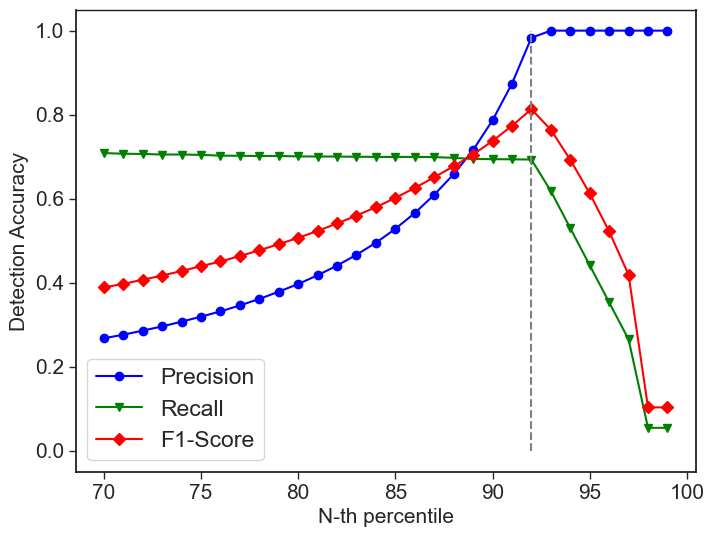

In [30]:
# DAGMM
rate = list(np.arange(30,0,-1))
Model_Names2 = ["DAGMM_h8_l4_n1","DAGMM_h8_l4_n2","DAGMM2_h8_l4_n1","DAGMM2_h8_l4_n2"]
DA_models = ["DAGMM_AE_h8_l4","DAGMM_AE_h8_l4","DAGMM_AE2_h8_l4","DAGMM_AE2_h8_l4"]
GMM_models = ["DAGMM_GMM_h8_l4_n1.pkl","DAGMM_GMM_h8_l4_n2.pkl","DAGMM_GMM2_h8_l4_n1.pkl","DAGMM_GMM2_h8_l4_n2.pkl"]
GMM_model = {}
for key in list(GMM_model.keys()):
    name = Model_Names2
    GMM_model[name] = GMM_model.pop(key)
k = 0
for i in Model_Names2:
    GMM_model[i] = calculate_result3(DA_models[k], GMM_models[k], rate)
    k+=1

percentile = list(np.arange(70,100,1))
# print(GMM_model[Model_Names2[0]][0][rate[0]][1]['precision'])

precision=[]
recall=[]
f1=[]
for i in list(range(len(rate))):
    precision.append(GMM_model[Model_Names2[1]][0][rate[i]][1]['precision'])
    recall.append(GMM_model[Model_Names2[1]][0][rate[i]][1]['recall'])
    f1.append(GMM_model[Model_Names2[1]][0][rate[i]][1]['f1'])
Max_f1 = f1.index(max(f1))

a = precision[19]
b = recall[19]
c = f1[19]
print(a,b,c)

# fig = plt.figure(figsize=[8, 6])
# ax = fig.subplots()
fig, ax = plt.subplots(figsize=[8, 6])
ax.plot(percentile, precision, label='Precision', color='blue', linestyle='-', marker='o')
ax.plot(percentile, recall, label='Recall', color='green', linestyle='-', marker='v')
ax.plot(percentile, f1, label='F1-Score', color='red', linestyle='-', marker='D')
ax.vlines(percentile[Max_f1], 0, 1, colors='gray', linestyles='--')
ax.set_xlabel('N-th percentile', fontsize= 15)
ax.set_ylabel('Detection Accuracy', fontsize= 15)
ax.legend(loc='lower left')
ax.grid(False)
ax.tick_params(labelsize=15, length=5, width=1, left=True, bottom=True)
ax.spines['top'].set_linewidth(1)
ax.spines['top'].set_color('k')
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')
ax.spines['right'].set_color('k')
plt.savefig("Detection Accuracy VS n-th percentile")

In [46]:
# Autoencoder
# Model_Names1 = ["AE2_h8_l4", "AE_origin_l4", "DAE2_h8_l4", "DAE_origin_l4"]
# AE_models = ["AE2_h8_l4", "AE_origin_l4", "DAE2_h8_l4", "DAE_origin_l4"]

Model_Names1 = ["AE_origin_l4","DAE_origin_l4"]
AE_models = ["AE_origin_l4","DAE_origin_l4"]
AE_model = {}
for key in list(AE_model.keys()):
    name = Model_Names1
    AE_model[name] = AE_model.pop(key)

for i in AE_models:
    AE_model[i] = calculate_result4(i)
    
# LABELS = ["Normal", "Abnormal"]
# conf_matrix = AE_model[Model_Names1[0]][1]['conf_matrix']
# plt.figure(figsize=(8, 8))
# sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, 
#             annot=True, fmt="d", annot_kws={'size': 20}, cmap="YlGnBu", 
#             vmin=0, vmax=4000);
# plt.text(0.05, 0.1, 'True Positive Rate', color="red", fontsize=13, fontweight="bold")
# plt.text(1.05, 0.1, 'False Negative Rate', color="red", fontsize=13, fontweight="bold")
# plt.text(0.05, 1.1, 'False Positive Rate', color="red", fontsize=13, fontweight="bold")
# plt.text(1.05, 1.1, 'True Negative Rate', color="red", fontsize=13, fontweight="bold")
# plt.title("Confusion matrix")
# plt.xlabel('Predicted class')
# plt.ylabel('True class')

# LABELS = ["Normal", "Abnormal"]
# conf_matrix = AE_model[Model_Names1[1]][1]['conf_matrix']
# plt.figure(figsize=(8, 8))
# sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, 
#             annot=True, fmt="d", annot_kws={'size': 20}, cmap="YlGnBu", 
#             vmin=0, vmax=4000);
# plt.text(0.05, 0.1, 'True Positive Rate', color="red", fontsize=13, fontweight="bold")
# plt.text(1.05, 0.1, 'False Negative Rate', color="red", fontsize=13, fontweight="bold")
# plt.text(0.05, 1.1, 'False Positive Rate', color="red", fontsize=13, fontweight="bold")
# plt.text(1.05, 1.1, 'True Negative Rate', color="red", fontsize=13, fontweight="bold")
# plt.title("Confusion matrix")
# plt.xlabel('Predicted class')
# plt.ylabel('True class')

# results_plot(AE_model, Model_Names1)
# plt.show();

# print(AE_model)
print(AE_model[Model_Names1[0]][1]['conf_matrix'])
# print(AE_model[Model_Names1[0]][1]['precision'])
# print(AE_model[Model_Names1[0]][1]['recall'])
# print(AE_model[Model_Names1[1]][1]['precision'])
# print(AE_model[Model_Names1[1]][1]['recall'])
# Model_Names의 첫번째 모델의 데이터 : AE_model[Model_Names[0]] 

# DAGMM
# rate = list(np.arange(7,12,0.2))
# Model_Names2 = ["DAGMM_h8_l4_n1","DAGMM_h8_l4_n2","DAGMM2_h8_l4_n1","DAGMM2_h8_l4_n2"]
# DA_models = ["DAGMM_AE_h8_l4","DAGMM_AE_h8_l4","DAGMM_AE2_h8_l4","DAGMM_AE2_h8_l4"]
# GMM_models = ["DAGMM_GMM_h8_l4_n1.pkl","DAGMM_GMM_h8_l4_n2.pkl","DAGMM_GMM2_h8_l4_n1.pkl","DAGMM_GMM2_h8_l4_n2.pkl"]
# Model_Names2 = ["DAGMM_h8_l4_n1", "DAGMM_h8_l4_n2"]
# DA_models = ["DAGMM_AE_h8_l4","DAGMM_AE_h8_l4"]
# GMM_models = ["DAGMM_GMM_h8_l4_n1.pkl","DAGMM_GMM_h8_l4_n2.pkl"]

# Model_Names2 = ["DAGMM_h8_l4_n1"]
# DA_models = ["DAGMM_AE_h8_l4"]
# GMM_models = ["DAGMM_GMM_h8_l4_n1.pkl"]

# GMM_model = {}
# for key in list(GMM_model.keys()):
#     name = Model_Names2
#     GMM_model[name] = GMM_model.pop(key)
# k = 0
# for i in Model_Names2:
#     GMM_model[i] = calculate_result2(DA_models[k], GMM_models[k], rate)
#     k+=1

# results_plot2(GMM_model, Model_Names2, rate)
# plt.legend(("N=1","N=2"))
# plt.show();

# print(GMM_model)
# print(GMM_model[Model_Names[0]][0][rate[0]][0]['fpr'])
# Model_Names의 첫번째 모델의 데이터 : GMM_model[Model_Names[0]]


# results_plot3(AE_model, GMM_model, Model_Names1, Model_Names2, rate)
# plt.legend(("AE","DAE","DAGMM"))
# plt.show();

115/556 [=====>........................] - ETA: 0s

2023-03-13 19:11:55.449036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


109/556 [====>.........................] - ETA: 0s

2023-03-13 19:11:57.599922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 1s 2ms/step


KeyError: 'conf_matrix'

In [ ]:
LABELS = ["Normal", "Abnormal"]
conf_matrix = GMM_model[Model_Names2[0]][0][rate[20]][1]['conf_matix']
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, 
            annot=True, fmt="d", annot_kws={'size': 20}, cmap="YlGnBu", 
            vmin=0, vmax=4000);
plt.text(0.05, 0.1, 'True Positive Rate', color="red", fontsize=13, fontweight="bold")
plt.text(1.05, 0.1, 'False Negative Rate', color="red", fontsize=13, fontweight="bold")
plt.text(0.05, 1.1, 'False Positive Rate', color="red", fontsize=13, fontweight="bold")
plt.text(1.05, 1.1, 'True Negative Rate', color="red", fontsize=13, fontweight="bold")
plt.title("Confusion matrix")
plt.xlabel('Predicted class')
plt.ylabel('True class')

LABELS = ["Normal", "Abnormal"]
conf_matrix = GMM_model[Model_Names2[1]][0][rate[4]][1]['conf_matix']
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, 
            annot=True, fmt="d", annot_kws={'size': 20}, cmap="YlGnBu", 
            vmin=0, vmax=4000);
plt.text(0.05, 0.1, 'True Positive Rate', color="red", fontsize=13, fontweight="bold")
plt.text(1.05, 0.1, 'False Negative Rate', color="red", fontsize=13, fontweight="bold")
plt.text(0.05, 1.1, 'False Positive Rate', color="red", fontsize=13, fontweight="bold")
plt.text(1.05, 1.1, 'True Negative Rate', color="red", fontsize=13, fontweight="bold")
plt.title("Confusion matrix")
plt.xlabel('Predicted class')
plt.ylabel('True class')